In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')


RendererRegistry.enable('jupyterlab')

In [2]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Anxiety_Level,Depression_Level,Insomnia_Level,OCD_Level,Date,Time,Time of Day,Musical_hobbies,Age_Grouped,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Low,Low,Low,Low,2022-08-27,19:29:02,Evening,Yes,18.0,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,High,Low,Low,Low,2022-08-27,19:57:31,Evening,No,63.0,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,High,High,High,Low,2022-08-27,21:28:18,Evening,No,18.0,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,High,High,Low,Low,2022-08-27,21:40:40,Evening,Yes,61.0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,High,Low,Medium,High,2022-08-27,21:54:47,Evening,No,18.0,10


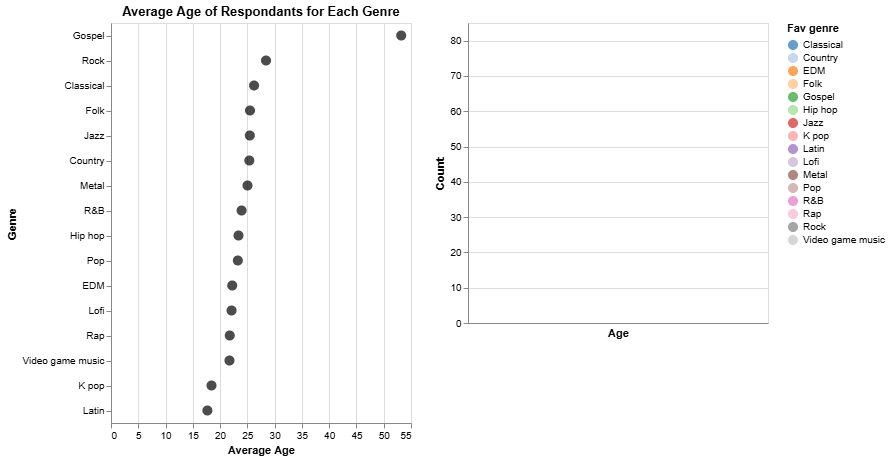

In [10]:
genre_stats = mxmh.groupby('Fav genre', as_index=False).agg(
    avg_age=('Age', 'mean'),
    count=('Age', 'count')
)

max_y = mxmh.groupby("Age_Grouped")["Fav genre"].count().max()
x_range = [10, 70]
color_scale = alt.Scale(domain=genre_stats['Fav genre'].tolist(), scheme='category20')
selection = alt.selection_point(fields=['Fav genre'], empty='none')

avg_age_bar_chart = alt.Chart(genre_stats).mark_point(size = 100, filled = True).encode(
    y=alt.Y('Fav genre:N', title="Genre", sort='-x'),
    x=alt.X('avg_age:Q', title="Average Age"),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale), alt.value('black')),
    tooltip=['Fav genre', 'avg_age', 'count']
).add_params(selection).properties(
    width=300,
    height=400,
    title="Average Age of Respondants for Each Genre"
    
)

age_hist = alt.Chart(mxmh).mark_bar().encode(
    alt.X('Age_Grouped:Q',  bin=alt.Bin(step=5), title="Age", scale=alt.Scale(domain=x_range)),
    alt.Y('count()', title="Count",scale=alt.Scale(domain=[0, max_y])),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale), alt.value('lightgray'))
).transform_filter(selection).properties(
    width=300,
    height=300
)
# Combine charts horizontally
chart = avg_age_bar_chart | age_hist
chart